In [65]:
#회귀(regression)는 연속된 출력 값을 예측하는 것이 목적(여러개의 클래스 중 하나의 클래스를 선택하는 classification과 차이)
#산점도 행렬을 위해 seaborn package 설치
!pip install -q seaborn

In [66]:
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.7.0


In [67]:
#UCI machine learning 저장소에서 dataset download
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

'/root/.keras/datasets/auto-mpg.data'

In [68]:
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names, na_values = "?", comment='\t', sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [69]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [70]:
#위의 결과를 토대로 누락된 행 삭제
dataset = dataset.dropna()

In [71]:
#Origin은 '수치형'이 아니라 '범주형'이기 때문에 one-hot encoding으로 변환
origin = dataset.pop('Origin')

In [72]:
dataset['USA'] = (origin == 1)*1.0
dataset['Europe'] = (origin == 2)*1.0
dataset['Japan'] = (origin == 3)*1.0
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


In [73]:
#data를 train_set과 test_set으로 분류한다
train_dataset = dataset.sample(frac=0.8, random_state=0) #fraction: 0.8 비율로 무작위 추출, random_state: 재현 가능하도록 난수의 초갓값 설정, 아무 수나 대입해도 상관없음.
test_dataset = dataset.drop(train_dataset.index)

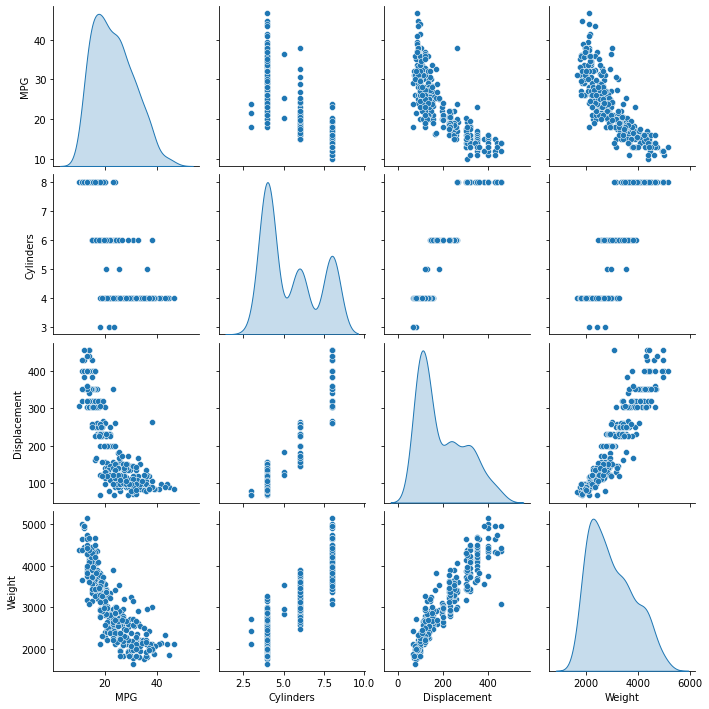

In [74]:
#data 조사
#training set에서 몇 개읭 ㅕㄹ을 선택해 산점도 행렬을 만들어 보자
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

In [75]:
#뿐만 아니라, 전반적인 통계도 확인해 보자
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


In [76]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

In [77]:
#data normalization
#각 특성의 범위가 다르므로 정규화 필요.
def norm(x):
  return (x-train_stats['mean'])/train_stats['std']

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [78]:
#model 만들기
def build_model():
  model = keras.Sequential([
                            layers.Dense(64, activation = 'relu', input_shape=[len(train_dataset.keys())]),
                            layers.Dense(64, activation = 'relu'),
                            layers.Dense(1)
                            ])
  optimizer = tf.keras.optimizers.RMSprop(0.001)
  model.compile(loss='mse', optimizer=optimizer, metrics=['mae', 'mse'])
  return model

In [79]:
model = build_model()

In [80]:
#model 확인
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 64)                640       
                                                                 
 dense_10 (Dense)            (None, 64)                4160      
                                                                 
 dense_11 (Dense)            (None, 1)                 65        
                                                                 
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [81]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.18546689],
       [-0.08005369],
       [-0.09635245],
       [-0.13421826],
       [-0.65421623],
       [ 0.07882557],
       [-0.6956718 ],
       [ 0.01799452],
       [-0.10228331],
       [-0.6272248 ]], dtype=float32)

In [82]:
#training model

#epoch가 끝날 때마다 점(.)을 출력해 training process를 표시합니다.
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

#1000번의 epoch동안 진행
EPOCHS = 1000

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS, validation_split = 0.2, verbose=0, callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [83]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,2.455371,1.052228,2.455371,8.502023,2.250699,8.502023,995
996,2.294536,0.985074,2.294536,9.483248,2.371451,9.483248,996
997,2.292242,0.975496,2.292242,8.624745,2.188960,8.624745,997
998,2.303262,0.987185,2.303262,9.717944,2.454641,9.717944,998
999,2.439352,1.050825,2.439352,8.766559,2.283883,8.766559,999


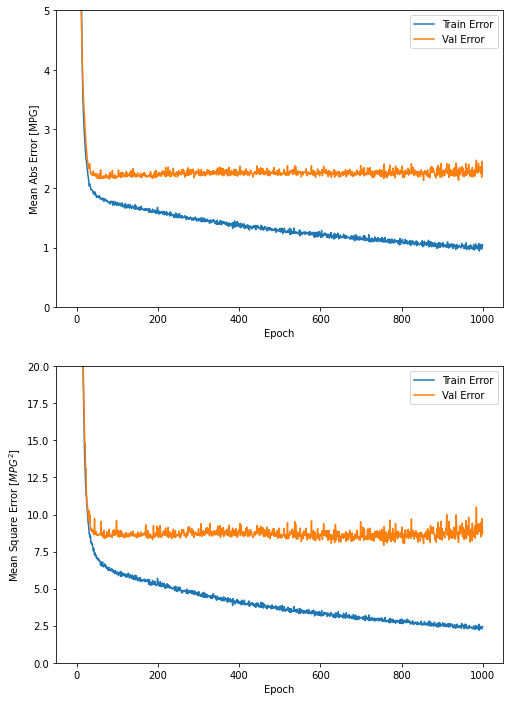

In [84]:
import matplotlib.pyplot as plt

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure(figsize=(8,12))

  plt.subplot(2,1,1)
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mae'], label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'], label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.subplot(2,1,2)
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'], label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'], label='Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()

plot_history(history)


....................................................................................

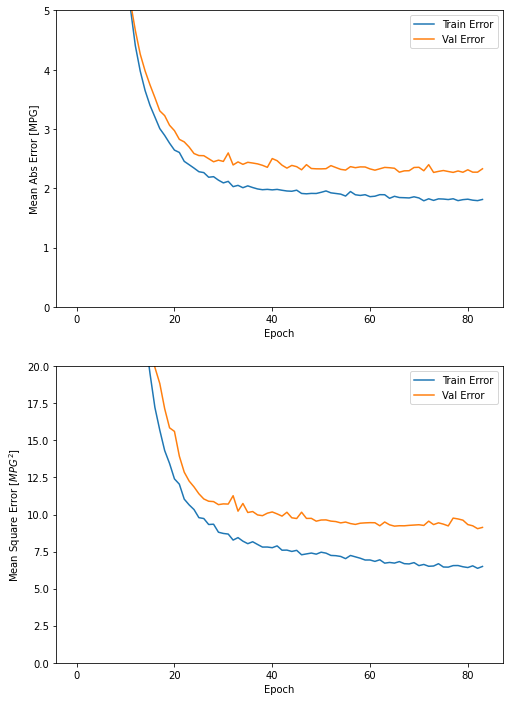

In [85]:
#위를 살펴봤을 때 특정 지점 이후부터는 모델이 거의 향상되지 않는다는 것을 알 수 있다.
#model.fit 메서드를 수정하여 검증 점수가 향상되지 않으면 자동으로 훈련을 멈추도록 만들자
#이를 위해, epoch마다 훈련 상태를 점검할 것이며 어 때에 EarlyStopping callback을 사용하겠다
model = build_model()

#여기서 patience는 성능 향상을 체크할 에포크 횟수이다
early_stop = keras.callbacks.EarlyStopping(monitor='val_mae', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS, validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

In [86]:
#test set에서 모델의 성능 측정
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print('테스트 세트의 평균 절대 오차: {:5.2f}'.format(mae))

3/3 - 0s - loss: 5.9320 - mae: 1.8017 - mse: 5.9320 - 19ms/epoch - 6ms/step
테스트 세트의 평균 절대 오차:  1.80


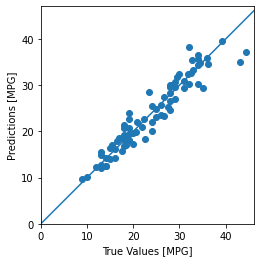

In [87]:
#predict
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

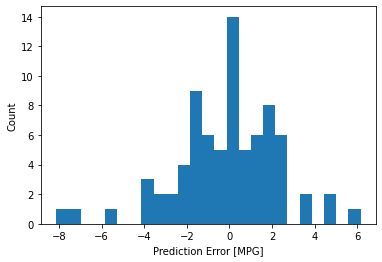

In [88]:
#오차의 분포를 살펴보자
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")